# CS445 Final Project - Seathru

In [43]:
import collections
import sys
import argparse
import numpy as np
import sklearn as sk
import scipy as sp
import scipy.optimize as optimize
import scipy.stats
import math
from PIL import Image
import rawpy
import matplotlib
from matplotlib import pyplot as plt
from skimage import exposure
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle, estimate_sigma
from skimage.morphology import closing, opening, erosion, dilation, disk, diamond, square

C:\Users\ellie\AppData\Local\Temp\ipykernel_25216\2851851223.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((size, size), Image.ANTIALIAS)
C:\Users\ellie\AppData\Local\Temp\ipykernel_25216\2851851223.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  raw_depth.thumbnail((size, size), Image.ANTIALIAS)


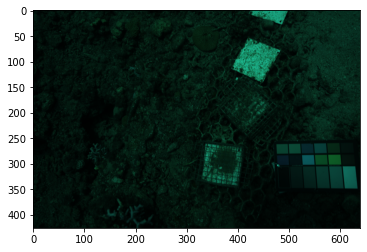

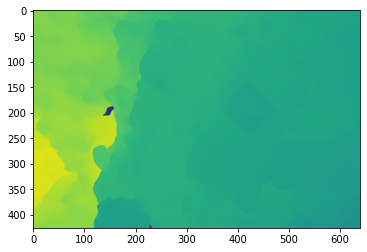

In [44]:
# Read Image and Depth file

img = Image.open("samples/img.png")
raw_depth = Image.open("samples/depth.tif")

size = 640

img.thumbnail((size, size), Image.ANTIALIAS)
raw_depth.thumbnail((size, size), Image.ANTIALIAS)

img = np.float32(img) / 255.0
raw_depth = np.array(raw_depth).astype(np.float32)

plt.imshow(img)
plt.show()

plt.imshow(raw_depth)
plt.show()

In [45]:
# CONSTANTS

min_depth = 0

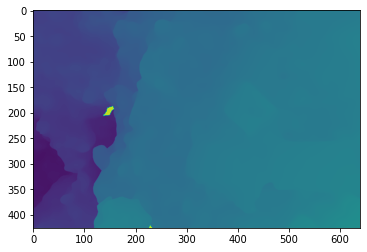

In [46]:
# Preprocess depth

# Normalize to 0-1 and scale based on inverse
depths = (raw_depth - np.min(raw_depth)) / (np.max(raw_depth) - np.min(raw_depth))
depths = (2 * (1.0 - depths)) + 2

plt.imshow(depths)
plt.show()

In [47]:
# Partition depth map into 10 bins and search for pixel value (r,g,b) in the bottom 1 percentile
def sample_backscatter_points(img, depths):
	# Divide depth over 10 bins (as in paper)
	depth_bins = np.histogram_bin_edges(depths, bins=10, range=(np.min(depths), np.max(depths)))
	mean_intensity = np.mean(img, axis=2)

	estimation_points = []

	for i in range(10):
		# Find idx of points with depth in bin and greater than min depth
		idx_in_bin = np.where((depths >= depth_bins[i]) & (depths <= depth_bins[i+1]) & (depths > (np.min(depths) + min_depth)))
		sorted_idx = np.argsort(mean_intensity[idx_in_bin])
		
		# Use bottom 1 percentile of triples (as in paper)
		num_points = math.ceil(0.01 * len(mean_intensity))
		
		for idx in sorted_idx[:num_points]:
			depth = depths[idx_in_bin][idx]
			pixel = img[idx_in_bin][idx]
			estimation_points.append([depth, pixel[0], pixel[1], pixel[2]]) 

	return np.array(estimation_points)

In [48]:
# [depth, r, g, b]
estimation_points = sample_backscatter_points(img, depths)

In [49]:
# Backscatter estimation from paper
def backscatter_model(depth, B_inf, beta_b, J, beta_d):
    return B_inf * (1 - np.exp(-beta_b * depth)) + J * np.exp(-beta_d * depth)

# Estimating B_inf, beta_b, J, beta_d subject to the bounds of [0,1],[0,5],[0,1], and [0,5]
def optimize_parameters(val, depth):
    parameters, _ = optimize.curve_fit(
        f=backscatter_model,
        xdata=depth,
        ydata=val,
        bounds=(np.array([0, 0, 0, 0]), np.array([1, 5, 1, 5]))
    )
    return parameters

# Estimate backscatter parameters for each channel
def estimate_backscatter(esimation_points):
    estimated_values = []
    parameters = []

    for channel in range(3):
        value, depth = esimation_points[:, channel+1], esimation_points[:, 0]
        
        parameter = optimize_parameters(value, depth)

        estimated_values.append(backscatter_model(depths, *parameter))
        parameters.append(parameter)

    return estimated_values, parameters

In [50]:
# [r_BackScatter, g_BackScatter, b_BackScatter], [r_params, g_params, b_params]
estimated_values, parameters = estimate_backscatter(estimation_points)

# For you
# TODO: Instead of using the following individually and calculating each channel with seperate method calls, try to vectorize
Br, Bg, Bb, coefsR, coefsG, coefsB = estimated_values[0], estimated_values[1], estimated_values[2], parameters[0], parameters[1], parameters[2]

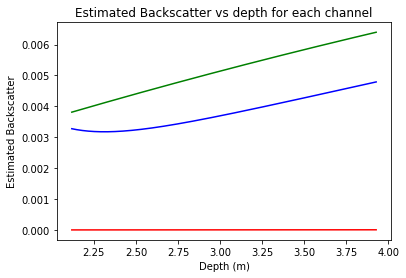

In [51]:
# Estimated Backscatter vs depth for each channel
for idx, color in enumerate(['r', 'g', 'b']):
    x = np.linspace(np.min(estimation_points[:, 0]), np.max(estimation_points[:, 0]), 1000)
    y = backscatter_model(x, *parameters[idx])
    plt.plot(x.ravel(), y.ravel(), c=color)

plt.xlabel('Depth (m)')
plt.ylabel('Estimated Backscatter')
plt.title('Estimated Backscatter vs depth for each channel')
plt.show()

In [52]:
def create_depth_groups(depth_data, epsilon, min_group_size):
	epsilon = (np.max(depth_data) - np.min(depth_data)) * epsilon
	depth_groups = np.zeros(depth_data.shape, dtype=np.int32)
	groups_counter = {}

	# Label depths data into groups based on epsilon for similarity
	remaining_points = np.argwhere(depth_groups == 0)
	id = 1
	while remaining_points.size > 0:
		start = remaining_points[np.random.choice(remaining_points.shape[0])]
		queue = collections.deque([start])
		
		while queue:
			curr = queue.pop()
			if np.abs(depth_data[curr[0], curr[1]] - depth_data[start[0], start[1]]) <= epsilon:
				depth_groups[curr[0], curr[1]] = id
				groups_counter[id] = groups_counter[id] + 1 if id in groups_counter else 1

				for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
					new_x, new_y = curr[0] + x, curr[1] + y
					if 0 <= new_x < depth_data.shape[0] and 0 <= new_y < depth_data.shape[1]:
						if depth_groups[new_x, new_y] == 0:
							queue.append([new_x, new_y])
		id += 1
		remaining_points = np.argwhere(depth_groups == 0)

	# Merge small groups with larger groups
	for label, size in groups_counter.items():
		if size < min_group_size:
			for x, y in zip(*np.where(depth_groups == label)):
				depth_groups[x, y] = bfs(depth_groups, x, y)

	# Use morphological smoothing (based on open source code)
	smoothed_groups = closing(depth_groups, square(3))

	return smoothed_groups

# BFS to search for a point's nearest neighbor thats not in its group
def bfs(depth_groups, x, y):
	original_label = depth_groups[x,y]
	checked = np.zeros_like(depth_groups, dtype=bool)
	queue = collections.deque([(x, y)])

	while queue:
		curr = queue.pop()
		if depth_groups[curr[0], curr[1]] != original_label:
			return depth_groups[curr[0], curr[1]]
		
		checked[curr[0], curr[1]] = True
		for x, y in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
			new_x, new_y = curr[0] + x, curr[1] + y
			if 0 <= new_x < depth_groups.shape[0] and 0 <= new_y < depth_groups.shape[1]:
				queue.append([new_x, new_y])
	return 0

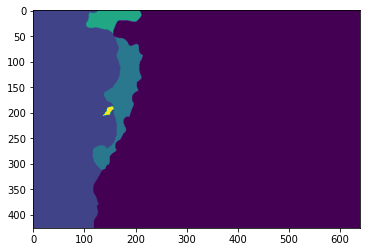

In [53]:
# Contruct a depth group map based on LSAC from paper

epsilon = 0.1
min_group_size = 50

depth_groups = create_depth_groups(depths, epsilon, min_group_size)
num_groups = len(np.unique(depth_groups))

plt.imshow(depth_groups)
plt.show()


In [67]:
def estimate_illumination(img, backscatter, neighborhood_map, num_neighborhoods, p=0.5, f=2.0, max_iters=100, tol=1E-5):
    D = img - backscatter # I = D + B
    avg_cs = np.zeros_like(img)
    avg_cs, avg_cs_prime = np.zeros(img.shape), np.zeros(img.shape)

    neighborhood_sizes = np.zeros(num_neighborhoods)
    neighborhood_locs = [None] * num_neighborhoods

    for i in range(num_neighborhoods):
        neighborhood_locs[i] = np.where(neighborhood_map == (i+1))
        neighborhood_sizes[i] = np.size(neighborhood_locs[i][0])

    # update average local contrasts
    for i in range(max_iters):
        for j in range(num_neighborhoods):
            locs = neighborhood_locs[j]
            size = neighborhood_sizes[j] - 1
            avg_cs_prime[locs] = (1/size) * (np.sum(avg_cs[locs])-avg_cs[locs])
        updated_avg = (D*p) + (avg_cs_prime*(1-p))
        abs_diff = np.abs(avg_cs-updated_avg)
        if np.max(abs_diff) < tol:
            break
        avg_cs = updated_avg
    
    result = f * denoise_bilateral(np.maximum(0, avg_cs))
    return result

In [68]:
illR = estimate_illumination(img[:,:,0], Br, depth_groups, num_groups)
illG = estimate_illumination(img[:,:,1], Bg, depth_groups, num_groups)
illB = estimate_illumination(img[:,:,2], Bb, depth_groups, num_groups)

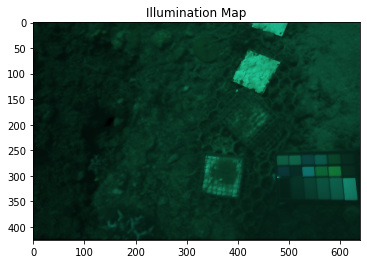

In [69]:
illumination = np.stack([illR, illG, illB], axis=2)

plt.imshow(illumination)
plt.title('Illumination Map')
plt.show()

In [ ]:
def filter_data(X, Y, radius_fraction=0.01):
    return None # TODO

In [70]:
def estimate_attentuation(depths, illumination, r=6, max_val=10.0, restarts=10, min_depth_fraction = 0.1, max_mean_loss_fraction=np.inf, l=1.0, radius_fraction=0.01):
    eps = 1E-8
    attentuations = []
    coefs = []
    z_max, z_min = max(depths), min(depths)
    min_depth = z_min + (min_depth_fraction*(z_max-z_min))
    max_mean_loss = max_mean_loss_fraction * (z_max-z_min) # edit

    for channel in range(3):
        ill = illumination[:,:,channel]
        val = -np.log(ill + eps) / (np.maximum(0, depths) + eps)
        BD = np.minimum(val, max_val)
        mask = np.where(np.logical_and(depths > eps, ill > eps), 1, 0)
        att = denoise_bilateral(closing(np.maximum(0, BD*mask), disk(r)))
        # attentuations.append(att)

        # refine
        best_loss = np.inf
        locs = np.where(np.logical_and(ill > 0, np.logical_and(depths > min_depth, att > eps)))
        dX, dY = filter_data(depths[locs], att[locs])
        for i in range(restarts):
            popt, pcov = sp.optimize.curve_fit(calculate_beta_D, dX, dY, p0=np.abs(np.random.random(4)) * np.array([1.0,-1.0,1.0,-1.0]), bounds=([0,-100,0,-100],[100,0,100,0]))
            loss = calculate_loss(depths, ill, locs, popt)
            if loss < best_loss:
                best_loss = loss
                c = popt

        if best_loss > max_mean_loss: # couldn't find accurate model, use linear model instead
            slope, intercept, rvalue, pvalue, stderr, intercept_stderr = sp.stats.linregress(depths[locs], att[locs])
            beta = (slope*depths) + intercept
            attentuations.append(l*beta)
            coefs.append(np.array([slope, intercept]))
        
        beta = l * calculate_beta_D(depths, *coefs)
        attentuations.append(beta)
        coefs.append(c)

    return attentuations, coefs

def calculate_loss(depths, illumination, locs, popt):
    eps = 1E-5
    res = -np.log(illumination+eps) / (calculate_beta_D(depths, popt)+eps)
    return np.mean(np.abs(depths[locs]-res))

def calculate_beta_D(depths, popt):
    return (popt[0]*np.exp(popt[1]*depths)) + (popt[2]*np.exp(popt[3]*depths))

In [71]:
attentuations, coefs = estimate_attentuation(depths, illumination)

betaR, betaG, betaB, coefsR, coefsG, coefsB = attentuations[0], attentuations[1], attentuations[2], coefs[0], coefs[1], coefs[2]

ValueError: too many values to unpack (expected 2)